In [1]:
import pandas as pd
from datetime import datetime
import MetaTrader5 as mt5
import pytz
import sys
import pickle
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score

import seaborn as sns

from Long_Short_Term_Memory import Long_Short_Term_Memory
from Optimize_Portfolio import PortfolioManagement
import ta
from scipy.stats import zscore
import numpy as np
import scipy.stats as st

import os
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

In [2]:
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 1, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2021, 9, 22, tzinfo=gc_o_TIME_ZONE)
gc_dt_SIMULATION_MODEL_FROM = "2021-09-01 00:00:00"


gc_a_SYMBOLS = []


gc_i_BACKWARD_TIME_WINDOW = -1
gc_i_FORWARD_TIME_WINDOW = 5


gc_dec_TRAINING_RATIO = 0.6
gc_dec_VALIDATION_RATIO = 0.2
gc_dec_TEST_RATIO = 0.2


gc_dec_MAX_RISK_RMSE = 0.10
gc_dec_INITIAL_BALANCE = 1000


g_aBackwardTimeSteps = range(gc_i_BACKWARD_TIME_WINDOW, 0)
g_aForwardTimeSteps = range(0, gc_i_FORWARD_TIME_WINDOW)

gc_i_PERIODS_OF_CLASSES = 5

g_aInputFeatures = set(['open', 'high', 'low', 'close', 'spread' ,'tick_volume'])
g_aOutputFeatures = pd.IntervalIndex.from_breaks(st.norm.ppf(np.linspace(0, 1, gc_i_PERIODS_OF_CLASSES+1)))

In [3]:
def ConvertSpreadValues(dfRates, aSymbolInfo):
    iDigits = aSymbolInfo.digits
    dfRates['spread'] = dfRates['spread'] * pow(10, -iDigits)

In [4]:
def dfShiftTimeSteps(dfRates, aTimeSteps):
    
    lstColumnNames = list([])
    for iTimeStep in aTimeSteps:
        for tplCol in dfRates.columns:
            lstColumnNames.append((iTimeStep, ) + tplCol)
    
    
    lstIndexNames = ("Time Step",) +  tuple(dfRates.columns.names)
    
    dicColumnIndices = pd.MultiIndex.from_tuples(
        lstColumnNames,
        names = lstIndexNames
        )


    dfShiftedRates = pd.DataFrame(
        columns=dicColumnIndices, 
        index=dfRates.index)
    
    

    for i in aTimeSteps:
        dfShiftedRates[i] = dfRates.shift(-i)

    dfShiftedRates.dropna(inplace=True)

    return dfShiftedRates

In [5]:
def dfGetMarketData(sSymbol):

    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()

    aRates = mt5.copy_rates_range(
        sSymbol, mt5.TIMEFRAME_M30, gc_dt_FROM, gc_dt_TO)
    if len(aRates) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()

    dfRates = pd.DataFrame(aRates)

    dfRates['time'] = pd.to_datetime(dfRates['time'], unit='s')
    dfRates.set_index('time', inplace=True)
    dfRates.drop('real_volume', axis=1, inplace=True)

    ConvertSpreadValues(dfRates, aSymbolInfo)
    AddSeasonalFeatures(dfRates)
    AddReturns(dfRates)
    dfRates = dfAddTechnicalIndicators(dfRates)

    dfRates.columns  = pd.MultiIndex.from_product(
        [[sSymbol], dfRates.columns], 
        names=["Time Series", "Feature"])
    
    
    return dfRates

In [6]:
def dfAddTechnicalIndicators(dfRates):
    global g_aInputFeatures 
    
    
    iTimeWindow = 24
    
    dfHigh = dfRates["high"]
    dfLow = dfRates["low"]
    dfClose = dfRates["close"]
    
    # Average Dricetional Movement Index
    oAdx = ta.trend.ADXIndicator(dfHigh, dfLow, dfClose, iTimeWindow, False)
    
    dfAdx = oAdx.adx()
    dfAdx.drop(dfAdx[dfAdx == 0].index, inplace = True)
    g_aInputFeatures.add(dfAdx.name)
    
    dfAdxNeg = oAdx.adx_neg()
    dfAdxNeg.drop(dfAdxNeg[dfAdxNeg == 0].index, inplace = True)
    g_aInputFeatures.add(dfAdxNeg.name)
    
    
    dfAdxPos = oAdx.adx_pos()
    dfAdxPos.drop(dfAdxPos[dfAdxPos == 0].index, inplace = True)
    g_aInputFeatures.add(dfAdxPos.name)
    
    
    dfRates = dfRates.join(dfAdx, how = "inner")
    dfRates = dfRates.join(dfAdxNeg, how = "inner")
    dfRates = dfRates.join(dfAdxPos, how = "inner")

    
    # Aroon Indicator
    oAroon = ta.trend.AroonIndicator(dfClose, iTimeWindow, False)
    dfAroonDown = oAroon.aroon_down()
    dfAroonDown.dropna(inplace = True)
    g_aInputFeatures.add(dfAroonDown.name)
    
    dfAroonIndicator = oAroon.aroon_indicator() 
    dfAroonIndicator.dropna(inplace = True)
    g_aInputFeatures.add(dfAroonIndicator.name)

    
    dfAroonUp = oAroon.aroon_up()
    dfAroonUp.dropna(inplace = True)
    g_aInputFeatures.add(dfAroonUp.name)
    
    dfRates = dfRates.join(dfAroonDown, how = "inner")
    dfRates = dfRates.join(dfAroonIndicator, how = "inner")
    dfRates = dfRates.join(dfAroonUp, how = "inner")
    
    
    # Commodity Channel Index
    oCci = ta.trend.CCIIndicator(dfHigh, dfLow,dfClose, iTimeWindow)
    dfCci = oCci.cci()
    dfCci.dropna(inplace = True)
    g_aInputFeatures.add(dfCci.name)
    
    dfRates = dfRates.join(dfCci, how = "inner")
    
    
    # Detrended Price Oscillator (DPO)
    oDpo = ta.trend.DPOIndicator(dfClose, iTimeWindow)
    dfDpo = oDpo.dpo()
    dfDpo.dropna(inplace = True)
    g_aInputFeatures.add(dfDpo.name)    
    
    dfRates = dfRates.join(dfDpo, how = "inner")
    
    
    # EMA - Exponential Moving Average
    oEma = ta.trend.EMAIndicator(dfClose, iTimeWindow)
    dfEma = oEma.ema_indicator()
    dfEma.dropna(inplace = True)
    g_aInputFeatures.add(dfEma.name)
    
    dfRates = dfRates.join(dfEma, how = "inner")
    
    
    return dfRates

In [7]:
def AddSeasonalFeatures(dfRates):
    global g_aInputFeatures 
    
    c_a_SEASONAL_FEATURES = ["year", "month", "day", "dayofweek", "hour"]
    for sSeasonalFeature in c_a_SEASONAL_FEATURES:
        exec("dfRates[sSeasonalFeature] = dfRates.index." + sSeasonalFeature)
        g_aInputFeatures.add(sSeasonalFeature)

In [8]:
def AddReturns(dfRates):
    dfRates["return"] = (dfRates["open"] - dfRates["close"])/dfRates["open"]

In [9]:
def dfOversampleImbalancedData(dfX, dfY):
    
#     oOversample = SMOTE()
#     aX, aY = oOversample.fit_resample(dfX.values, dfY.values)
    
#     dfX = pd.DataFrame(data = aX, columns = dfX.columns)
#     dfY = pd.DataFrame(data = aY, columns = dfY.columns)
    
    dfXCopy = dfX.copy()
    dfYCopy = dfY.copy()
        
    dfCombinations = dfYCopy.astype(str).agg('-'.join, axis=1)
    dfCombinationsStats = dfCombinations.value_counts()
    dfCombinationsStats = pd.DataFrame(dfCombinationsStats).reset_index()
    
    
    iMaxAmount = dfCombinationsStats.iloc[0,1]
    for i in range(1, len(dfCombinationsStats) ):
        
        sCombination = dfCombinationsStats.iloc[i, 0]
        iSamplesNeeded = iMaxAmount - dfCombinationsStats.iloc[i, 1]
        
        dfSampledIndex =  dfCombinations[dfCombinations == sCombination].sample(iSamplesNeeded, replace = True).index
        
        dfSampledX = dfXCopy.loc[dfSampledIndex]
        dfSampledY = dfYCopy.loc[dfSampledIndex]
        
    
        dfX = dfX.append(dfSampledX , ignore_index= True)
        dfY = dfY.append(dfSampledY , ignore_index= True)
        
    
    dfX,dfY = shuffle(dfX,dfY )
    

    return dfX, dfY

In [10]:
def dfSplitData(dfInput, dfOutput):
    dfInputTrainValidation, dfInputTest, dfOutputTrainValidation, dfOutputTest = train_test_split(
        dfInput,
        dfOutput,
        test_size=gc_dec_TEST_RATIO,
        shuffle=False)

    dfInputTrain, dfInputValidation, dfOutputTrain, dfOutputValidation = train_test_split(
        dfInputTrainValidation,
        dfOutputTrainValidation,
        test_size=(1/(1 -gc_dec_TEST_RATIO))-1,
        shuffle=False)
    
    
    dfInputTrain = dfInputTrain.astype(float)
    dfInputValidation = dfInputValidation.astype(float)
    dfInputTest = dfInputTest.astype(float)
    dfOutputTrain = dfOutputTrain.astype(float)
    dfOutputValidation = dfOutputValidation.astype(float)
    dfOutputTest = dfOutputTest.astype(float)
    
    return dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest

In [11]:
def dfScaleData(sScalerName,dfTrain,dfValidation, dfTest):
    sScalersDirectory = os.path.join(sSubModelName , "__scalers__")

    oScaler =StandardScaler()

    oScaler.fit(dfTrain)

    aScaledTrain = oScaler.transform(dfTrain)
    aScaledValidation = oScaler.transform(dfValidation)
    aScaledTest = oScaler.transform(dfTest)

    dfScaledTrain = pd.DataFrame(aScaledTrain, columns = dfTrain.columns, index = dfTrain.index)
    dfScaledValidation = pd.DataFrame(aScaledValidation, columns = dfValidation.columns, index = dfValidation.index)
    dfScaledTest = pd.DataFrame(aScaledTest, columns = dfTest.columns, index = dfTest.index)

    sScalerFilePath =os.path.join(sScalersDirectory, sScalerName + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))
    
    
    return dfScaledTrain, dfScaledValidation, dfScaledTest

In [12]:
sSymbol = "NAT.GAS"
aRelevantSymbols = []

In [13]:
dfRates = dfGetMarketData(sSymbol)

for sRelevantSymbol in aRelevantSymbols:
    dfRelevantRates = dfGetMarketData(sRelevantSymbol)
    dfRates = dfRates.join(dfRelevantRates, how = "inner")

C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [14]:
dfRates 

Time Series         NAT.GAS                                                \
Feature                open   high    low  close tick_volume spread  year   
time                                                                        
2021-01-05 01:30:00   2.582  2.589  2.582  2.588         148  0.010  2021   
2021-01-05 02:00:00   2.588  2.589  2.583  2.587         153  0.010  2021   
2021-01-05 02:30:00   2.586  2.592  2.585  2.588         129  0.011  2021   
2021-01-05 03:00:00   2.589  2.602  2.588  2.602         270  0.011  2021   
2021-01-05 03:30:00   2.601  2.601  2.595  2.599         136  0.011  2021   
...                     ...    ...    ...    ...         ...    ...   ...   
2021-09-21 21:30:00   4.843  4.864  4.840  4.849         799  0.005  2021   
2021-09-21 22:00:00   4.849  4.885  4.848  4.879         671  0.005  2021   
2021-09-21 22:30:00   4.879  4.888  4.862  4.872         679  0.005  2021   
2021-09-21 23:00:00   4.872  4.873  4.849  4.855         409  0.010  2021   
2021-09-21 23:30:00   4.855  4.857  4.828  4.832         230  0.010  2021   

Time Series                              ...                                  \
Feature             month day dayofweek  ...    return        adx    adx_neg   
time                                     ...                                   
2021-01-05 01:30:00     1   5         1  ... -0.002324  18.732942  22.124691   
2021-01-05 02:00:00     1   5         1  ...  0.000386  18.538557  21.748555   
2021-01-05 02:30:00     1   5         1  ... -0.000773  18.244230  21.307561   
2021-01-05 03:00:00     1   5         1  ... -0.005021  17.621825  20.442495   
2021-01-05 03:30:00     1   5         1  ...  0.000769  17.025352  20.018462   
...                   ...  ..       ...  ...       ...        ...        ...   
2021-09-21 21:30:00     9  21         1  ... -0.001239  21.460824  27.739579   
2021-09-21 22:00:00     9  21         1  ... -0.006187  21.341199  26.658781   
2021-09-21 22:30:00     9  21         1  ...  0.001435  21.190593  25.918313   
2021-09-21 23:00:00     9  21         1  ...  0.003489  21.155493  26.654375   
2021-09-21 23:30:00     9  21         1  ...  0.004737  21.291022  28.109943   

Time Series                                                            \
Feature                adx_pos aroon_down_24 aroon_ind_24 aroon_up_24   
time                                                                    
2021-01-05 01:30:00  16.667519     66.666667   -41.666667   25.000000   
2021-01-05 02:00:00  16.384159     62.500000   -41.666667   20.833333   
2021-01-05 02:30:00  16.920949     58.333333   -41.666667   16.666667   
2021-01-05 03:00:00  19.133904     54.166667   -41.666667   12.500000   
2021-01-05 03:30:00  18.737015     50.000000   -41.666667    8.333333   
...                        ...           ...          ...         ...   
2021-09-21 21:30:00  16.741784     75.000000   -45.833333   29.166667   
2021-09-21 22:00:00  18.300860     70.833333   -45.833333   25.000000   
2021-09-21 22:30:00  18.113029     66.666667   -45.833333   20.833333   
2021-09-21 23:00:00  17.641062     62.500000   -45.833333   16.666667   
2021-09-21 23:30:00  17.079914     58.333333   -45.833333   12.500000   

Time Series                                         
Feature                    cci    dpo_24    ema_24  
time                                                
2021-01-05 01:30:00 -27.331487 -0.006958  2.590461  
2021-01-05 02:00:00 -24.385511 -0.013083  2.590184  
2021-01-05 02:30:00 -12.569691 -0.011458  2.590010  
2021-01-05 03:00:00  29.306931 -0.013125  2.590969  
2021-01-05 03:30:00  31.773597 -0.006375  2.591611  
...                        ...       ...       ...  
2021-09-21 21:30:00 -50.402653 -0.000917  4.889529  
2021-09-21 22:00:00 -31.879393  0.043042  4.888687  
2021-09-21 22:30:00 -26.149548 -0.006917  4.887352  
2021-09-21 23:00:00 -34.438907 -0.007458  4.884764  
2021-09-21 23:30:00 -47.183227 -0.086042  4.880543  

[8464 rows x 21 columns]

In [15]:
dfInput  = dfRates.loc[:, dfRates.columns.get_level_values(1).isin(g_aInputFeatures)]
dfInput = dfShiftTimeSteps(dfInput, g_aBackwardTimeSteps)

In [16]:
dfInput

Time Step                -1                                                  \
Time Series         NAT.GAS                                                   
Feature                open   high    low  close tick_volume spread    year   
time                                                                          
2021-01-05 02:00:00   2.582  2.589  2.582  2.588       148.0  0.010  2021.0   
2021-01-05 02:30:00   2.588  2.589  2.583  2.587       153.0  0.010  2021.0   
2021-01-05 03:00:00   2.586  2.592  2.585  2.588       129.0  0.011  2021.0   
2021-01-05 03:30:00   2.589  2.602  2.588  2.602       270.0  0.011  2021.0   
2021-01-05 04:00:00   2.601  2.601  2.595  2.599       136.0  0.011  2021.0   
...                     ...    ...    ...    ...         ...    ...     ...   
2021-09-21 21:30:00   4.824  4.844  4.810  4.843      1570.0  0.008  2021.0   
2021-09-21 22:00:00   4.843  4.864  4.840  4.849       799.0  0.005  2021.0   
2021-09-21 22:30:00   4.849  4.885  4.848  4.879       671.0  0.005  2021.0   
2021-09-21 23:00:00   4.879  4.888  4.862  4.872       679.0  0.005  2021.0   
2021-09-21 23:30:00   4.872  4.873  4.849  4.855       409.0  0.010  2021.0   

Time Step                                                              \
Time Series                                                             
Feature             month   day dayofweek  hour        adx    adx_neg   
time                                                                    
2021-01-05 02:00:00   1.0   5.0       1.0   1.0  18.732942  22.124691   
2021-01-05 02:30:00   1.0   5.0       1.0   2.0  18.538557  21.748555   
2021-01-05 03:00:00   1.0   5.0       1.0   2.0  18.244230  21.307561   
2021-01-05 03:30:00   1.0   5.0       1.0   3.0  17.621825  20.442495   
2021-01-05 04:00:00   1.0   5.0       1.0   3.0  17.025352  20.018462   
...                   ...   ...       ...   ...        ...        ...   
2021-09-21 21:30:00   9.0  21.0       1.0  21.0  21.318925  28.456738   
2021-09-21 22:00:00   9.0  21.0       1.0  21.0  21.460824  27.739579   
2021-09-21 22:30:00   9.0  21.0       1.0  22.0  21.341199  26.658781   
2021-09-21 23:00:00   9.0  21.0       1.0  22.0  21.190593  25.918313   
2021-09-21 23:30:00   9.0  21.0       1.0  23.0  21.155493  26.654375   

Time Step                                                              \
Time Series                                                             
Feature                adx_pos aroon_down_24 aroon_ind_24 aroon_up_24   
time                                                                    
2021-01-05 02:00:00  16.667519     66.666667   -41.666667   25.000000   
2021-01-05 02:30:00  16.384159     62.500000   -41.666667   20.833333   
2021-01-05 03:00:00  16.920949     58.333333   -41.666667   16.666667   
2021-01-05 03:30:00  19.133904     54.166667   -41.666667   12.500000   
2021-01-05 04:00:00  18.737015     50.000000   -41.666667    8.333333   
...                        ...           ...          ...         ...   
2021-09-21 21:30:00  15.020175     79.166667   -45.833333   33.333333   
2021-09-21 22:00:00  16.741784     75.000000   -45.833333   29.166667   
2021-09-21 22:30:00  18.300860     70.833333   -45.833333   25.000000   
2021-09-21 23:00:00  18.113029     66.666667   -45.833333   20.833333   
2021-09-21 23:30:00  17.641062     62.500000   -45.833333   16.666667   

Time Step                                           
Time Series                                         
Feature                    cci    dpo_24    ema_24  
time                                                
2021-01-05 02:00:00 -27.331487 -0.006958  2.590461  
2021-01-05 02:30:00 -24.385511 -0.013083  2.590184  
2021-01-05 03:00:00 -12.569691 -0.011458  2.590010  
2021-01-05 03:30:00  29.306931 -0.013125  2.590969  
2021-01-05 04:00:00  31.773597 -0.006375  2.591611  
...                        ...       ...       ...  
2021-09-21 21:30:00 -69.497198  0.053083  4.893054  
2021-09-21 22:00:00 -50.402653 -0.00091

In [17]:
i = 1
j = 3

In [18]:
aColumns = pd.MultiIndex.from_tuples(
    [(i,j)],
    names = ["From","To"])

In [19]:
dfOutput = pd.DataFrame(index = dfInput.index, 
                        columns = aColumns)

    
dfSpread = dfRates[sSymbol]["spread"]
dfOpen = dfRates[sSymbol]["open"].shift(-i)
dfClose = dfRates[sSymbol]["close"].shift(-j)

dfNetReturn = (abs(dfClose - dfOpen) - dfSpread)
dfReturn = (dfClose - dfOpen)/dfOpen

# INVESTABILITY MODEL

In [20]:
sModelName = os.path.join(sSymbol , "__investability model__")

In [21]:
sSubModelName = os.path.join(sModelName , "__"+ str(i) +"  " + str(j) + "__")

## Preprocessing

In [22]:
dfInputInvestability = dfInput.copy()
dfOutputInvestability = dfOutput.copy()

In [23]:
dfMaskNonInvestable = dfNetReturn<=0
dfMaskInvestable = dfNetReturn>0

dfOutputInvestability.loc[dfMaskNonInvestable] = 0
dfOutputInvestability.loc[dfMaskInvestable] = 1

In [24]:
dfOutputInvestability

From,1
To,3
time,
2021-01-05 02:00:00,1
2021-01-05 02:30:00,1
2021-01-05 03:00:00,0
2021-01-05 03:30:00,0
2021-01-05 04:00:00,0
...,...
2021-09-21 21:30:00,1
2021-09-21 22:00:00,1


### Remove Empty Rows

In [25]:
aMissingOutputs = dfOutputInvestability[dfOutputInvestability.isna().any(axis=1)].index
dfInputInvestability.drop(aMissingOutputs, inplace = True)
dfOutputInvestability.drop(aMissingOutputs, inplace = True)

### Split Data

In [26]:
dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest = dfSplitData(dfInputInvestability, 
                                                                                                            dfOutputInvestability)

### Scale Data

In [27]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData("input", dfInputTrain,dfInputValidation, dfInputTest )

### Balance Classes

In [28]:
dfOutputTrain.value_counts()

(1, 3)
0.0       3171
1.0       1905
dtype: int64

In [29]:
dfBalancedInputTrain , dfBalancedOutputTrain = dfOversampleImbalancedData(
    dfScaledInputTrain,
    dfOutputTrain)
dfBalancedOutputTrain.columns = aColumns

In [30]:
dfBalancedOutputTrain.value_counts()

(1, 3)
0.0       3171
1.0       3171
dtype: int64

In [31]:
dfOutputValidation.value_counts()

(1, 3)
0.0       1008
1.0        684
dtype: int64

In [32]:
dfOutputTest.value_counts()

(1, 3)
1.0       871
0.0       821
dtype: int64

## Train

Epoch 1/10000
100/100 [==============================] - 21s 29ms/step - loss: 0.6874 - val_loss: 0.6702
Epoch 2/10000
100/100 [==============================] - 2s 18ms/step - loss: 0.6816 - val_loss: 0.6657
Epoch 3/10000
100/100 [==============================] - 2s 17ms/step - loss: 0.6761 - val_loss: 0.6618
Epoch 4/10000
100/100 [==============================] - 2s 19ms/step - loss: 0.6707 - val_loss: 0.6587
Epoch 5/10000
100/100 [==============================] - 2s 16ms/step - loss: 0.6654 - val_loss: 0.6561
Epoch 6/10000
100/100 [==============================] - 1s 12ms/step - loss: 0.6603 - val_loss: 0.6540
Epoch 7/10000
100/100 [==============================] - 1s 12ms/step - loss: 0.6553 - val_loss: 0.6524
Epoch 8/10000
100/100 [==============================] - 1s 14ms/step - loss: 0.6502 - val_loss: 0.6512
Epoch 9/10000
100/100 [==============================] - 1s 14ms/step - loss: 0.6451 - val_loss: 0.6504
Epoch 10/10000
100/100 [==============================] - 1s 12

100/100 [==============================] - 1s 7ms/step - loss: 0.5494 - val_loss: 0.5873
Epoch 80/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.5492 - val_loss: 0.5871
Epoch 81/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.5490 - val_loss: 0.5867
Epoch 82/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.5488 - val_loss: 0.5862
Epoch 83/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.5486 - val_loss: 0.5859
Epoch 84/10000
100/100 [==============================] - 1s 9ms/step - loss: 0.5484 - val_loss: 0.5857
Epoch 85/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.5483 - val_loss: 0.5852
Epoch 86/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.5481 - val_loss: 0.5849
Epoch 87/10000
100/100 [==============================] - 1s 9ms/step - loss: 0.5479 - val_loss: 0.5843
Epoch 88/10000
100/100 [==============================] - 1s 8ms/step - loss: 0

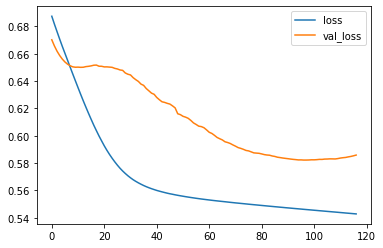

In [33]:
oPredictiveModel = Long_Short_Term_Memory(
    sSubModelName, 
    dfScaledInputTrain.shape[1], 
    1,
    len(g_aBackwardTimeSteps), 
    1
    )

oPredictiveModel.Train(dfBalancedInputTrain, 
                       dfBalancedOutputTrain,
                       dfScaledInputValidation,
                       dfOutputValidation
                      )

## Test

In [34]:
aPredictionProb, _ = oPredictiveModel.aPredict(dfScaledInputTest)

aPrediction = aPredictionProb.round()

dfPrediction = pd.DataFrame(aPrediction, index = dfInputTest.index)
dfPrediction.columns = aColumns

In [35]:
dfPrediction.value_counts()

(1, 3)
1.0       941
0.0       751
dtype: int64

In [36]:
print(classification_report(dfOutputTest, dfPrediction))

              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64       821
         1.0       0.66      0.72      0.69       871

    accuracy                           0.67      1692
   macro avg       0.67      0.67      0.67      1692
weighted avg       0.67      0.67      0.67      1692



# DIRECTIONAL MODEL

In [37]:
sModelName = os.path.join(sSymbol , "__directional model__")

In [38]:
sSubModelName = os.path.join(sModelName , "__"+ str(i) +"  " + str(j) + "__")

## Preprocessing

In [39]:
dfInputDirectional = dfInput.copy()
dfOutputDirectional = dfOutput.copy()

In [40]:
dfMaskUpward = dfClose>dfOpen
dfMaskDownward = dfClose<dfOpen 

dfOutputDirectional.loc[(dfMaskInvestable) & (dfMaskDownward)] = 0
dfOutputDirectional.loc[(dfMaskInvestable) & (dfMaskUpward)] = 1

In [41]:
dfOutputDirectional

From,1
To,3
time,
2021-01-05 02:00:00,1
2021-01-05 02:30:00,1
2021-01-05 03:00:00,NaN
2021-01-05 03:30:00,NaN
2021-01-05 04:00:00,NaN
...,...
2021-09-21 21:30:00,1
2021-09-21 22:00:00,0


### Remove Empty Rows

In [42]:
aMissingOutputs = dfOutputDirectional[dfOutputDirectional.isna().any(axis=1)].index
dfInputDirectional.drop(aMissingOutputs, inplace = True)
dfOutputDirectional.drop(aMissingOutputs, inplace = True)

### Split Data

In [43]:
dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest = dfSplitData(dfInputDirectional, 
                                                                                                            dfOutputDirectional)

### Scale Data

In [44]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData("input", dfInputTrain,dfInputValidation, dfInputTest)

### Balance Classes

In [45]:
dfOutputTrain.value_counts()

(1, 3)
1.0       1073
0.0       1003
dtype: int64

In [46]:
dfBalancedInputTrain , dfBalancedOutputTrain = dfOversampleImbalancedData(
    dfScaledInputTrain,
    dfOutputTrain)
dfBalancedOutputTrain.columns = aColumns

In [47]:
dfBalancedOutputTrain.value_counts()

(1, 3)
0.0       1073
1.0       1073
dtype: int64

In [48]:
dfOutputValidation.value_counts()

(1, 3)
1.0       371
0.0       321
dtype: int64

In [49]:
dfOutputTest.value_counts()

(1, 3)
1.0       382
0.0       310
dtype: int64

## Train

Epoch 1/10000
34/34 [==============================] - 3s 21ms/step - loss: 0.6935 - val_loss: 0.7048
Epoch 2/10000
34/34 [==============================] - 0s 7ms/step - loss: 0.6935 - val_loss: 0.7049
Epoch 3/10000
34/34 [==============================] - 0s 7ms/step - loss: 0.6934 - val_loss: 0.7050
Epoch 4/10000
34/34 [==============================] - 0s 7ms/step - loss: 0.6933 - val_loss: 0.7051
Epoch 5/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.7052
Epoch 6/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.7053
Epoch 7/10000
34/34 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.7055
Epoch 8/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.7056
Epoch 9/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.7057
Epoch 10/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.6928 - val_l

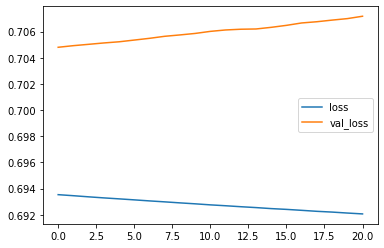

In [50]:
oPredictiveModel = Long_Short_Term_Memory(
    sSubModelName, 
    dfScaledInputTrain.shape[1], 
    1,
    len(g_aBackwardTimeSteps), 
    1
    )

oPredictiveModel.Train(dfBalancedInputTrain, 
                       dfBalancedOutputTrain,
                       dfScaledInputValidation,
                       dfOutputValidation
                      )

## Test

In [51]:
aPredictionProb, _ = oPredictiveModel.aPredict(dfScaledInputTest)

aPrediction = aPredictionProb.round()

dfPrediction = pd.DataFrame(aPrediction, index = dfInputTest.index)
dfPrediction.columns = aColumns

In [52]:
dfPrediction.value_counts()

(1, 3)
0.0       692
dtype: int64

In [53]:
print(classification_report(dfOutputTest, dfPrediction))

              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62       310
         1.0       0.00      0.00      0.00       382

    accuracy                           0.45       692
   macro avg       0.22      0.50      0.31       692
weighted avg       0.20      0.45      0.28       692



C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# UPWARD REGRESSION MODEL

In [54]:
sModelName = os.path.join(sSymbol , "__upward regression model__")

In [55]:
sSubModelName = os.path.join(sModelName , "__"+ str(i) +"  " + str(j) + "__")

## Preprocessing

In [112]:
dfInputUpward = dfInput.copy()
dfOutputUpward = dfOutput.copy()

In [113]:
dfOutputUpward.loc[dfMaskInvestable & dfMaskUpward, i] = dfReturn.loc[dfOutputUpward.index].loc[dfMaskInvestable & dfMaskUpward].values

In [114]:
dfOutputUpward

From,1
To,3
time,
2021-01-05 02:00:00,0.005027
2021-01-05 02:30:00,0.004635
2021-01-05 03:00:00,NaN
2021-01-05 03:30:00,NaN
2021-01-05 04:00:00,NaN
...,...
2021-09-21 21:30:00,0.001237
2021-09-21 22:00:00,NaN


### Remove Empty Rows

In [115]:
aMissingOutputs = dfOutputUpward[dfOutputUpward.isna().any(axis=1)].index
dfInputUpward.drop(aMissingOutputs, inplace = True)
dfOutputUpward.drop(aMissingOutputs, inplace = True)

### Split Data

In [116]:
dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest = dfSplitData(dfInputUpward, 
                                                                                                            dfOutputUpward)

### Scale Data

In [61]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData("input", dfInputTrain,dfInputValidation, dfInputTest)

In [62]:
dfScaledOutputTrain, dfScaledOutputValidation, dfOutputInputTest = dfScaleData("output", dfOutputTrain,dfOutputValidation, dfOutputTest)

### Independent Component Analysis

In [93]:
from sklearn.decomposition import FastICA

oTransformerIca = FastICA(n_components=5,random_state=0)

dfTransformedInputTrain = pd.DataFrame(data = oTransformerIca.fit_transform(dfScaledInputTrain), 
                                       index = dfScaledInputTrain.index)

dfTransformedInputValidation = pd.DataFrame(data = oTransformerIca.transform(dfScaledInputValidation), 
                                       index = dfScaledInputValidation.index)

dfTransformedInputTest = pd.DataFrame(data = oTransformerIca.transform(dfScaledInputTest), 
                                       index = dfScaledInputTest.index)

In [100]:
dfTransformedInputTrain.shape

(1095, 5)

In [101]:
dfTransformedInputValidation.shape

(365, 5)

In [102]:
dfTransformedInputTest.shape

(366, 5)

## Train

In [94]:
iNumberOfHiddenNeuron = dfScaledInputTrain.shape[1] * 2
iBatchSize = 32
oOptimizer = tf.keras.optimizers.Adam(learning_rate= 1e-05, beta_1=0.9)
oLossFunction = tf.keras.losses.MeanSquaredError()
oEarlyStop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0 , patience = 20)
iEpochSize = 10000

In [95]:
oPredictiveModel = Sequential()
oPredictiveModel.add(Dense((iNumberOfHiddenNeuron)))
oPredictiveModel.add(Dense((iNumberOfHiddenNeuron)))
oPredictiveModel.add(Dense((1)))

oPredictiveModel.compile(optimizer=oOptimizer, loss=oLossFunction)

Epoch 1/10000
35/35 [==============================] - 1s 6ms/step - loss: 1.0024 - val_loss: 0.6863
Epoch 2/10000
35/35 [==============================] - 0s 4ms/step - loss: 1.0022 - val_loss: 0.6862
Epoch 3/10000
35/35 [==============================] - 0s 5ms/step - loss: 1.0022 - val_loss: 0.6861
Epoch 4/10000
35/35 [==============================] - 0s 3ms/step - loss: 1.0022 - val_loss: 0.6860
Epoch 5/10000
35/35 [==============================] - 0s 4ms/step - loss: 1.0021 - val_loss: 0.6858
Epoch 6/10000
35/35 [==============================] - 0s 3ms/step - loss: 1.0021 - val_loss: 0.6857
Epoch 7/10000
35/35 [==============================] - 0s 3ms/step - loss: 1.0020 - val_loss: 0.6855
Epoch 8/10000
35/35 [==============================] - 0s 3ms/step - loss: 1.0020 - val_loss: 0.6854
Epoch 9/10000
35/35 [==============================] - 0s 3ms/step - loss: 1.0019 - val_loss: 0.6853
Epoch 10/10000
35/35 [==============================] - 0s 3ms/step - loss: 1.0019 - val_lo

35/35 [==============================] - 0s 9ms/step - loss: 0.9995 - val_loss: 0.6776
Epoch 82/10000
35/35 [==============================] - 0s 9ms/step - loss: 0.9994 - val_loss: 0.6775
Epoch 83/10000
35/35 [==============================] - 0s 9ms/step - loss: 0.9994 - val_loss: 0.6774
Epoch 84/10000
35/35 [==============================] - 0s 9ms/step - loss: 0.9994 - val_loss: 0.6773
Epoch 85/10000
35/35 [==============================] - 0s 9ms/step - loss: 0.9993 - val_loss: 0.6773
Epoch 86/10000
35/35 [==============================] - 0s 9ms/step - loss: 0.9993 - val_loss: 0.6772
Epoch 87/10000
35/35 [==============================] - 0s 9ms/step - loss: 0.9993 - val_loss: 0.6771
Epoch 88/10000
35/35 [==============================] - 0s 10ms/step - loss: 0.9993 - val_loss: 0.6770
Epoch 89/10000
35/35 [==============================] - 0s 9ms/step - loss: 0.9992 - val_loss: 0.6770
Epoch 90/10000
35/35 [==============================] - 0s 9ms/step - loss: 0.9992 - val_loss: 0

Epoch 161/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.9974 - val_loss: 0.6735
Epoch 162/10000
35/35 [==============================] - 0s 6ms/step - loss: 0.9974 - val_loss: 0.6735
Epoch 163/10000
35/35 [==============================] - 0s 4ms/step - loss: 0.9974 - val_loss: 0.6734
Epoch 164/10000
35/35 [==============================] - 0s 4ms/step - loss: 0.9973 - val_loss: 0.6734
Epoch 165/10000
35/35 [==============================] - 0s 5ms/step - loss: 0.9973 - val_loss: 0.6733
Epoch 166/10000
35/35 [==============================] - 0s 4ms/step - loss: 0.9973 - val_loss: 0.6733
Epoch 167/10000
35/35 [==============================] - 0s 3ms/step - loss: 0.9973 - val_loss: 0.6733
Epoch 168/10000
35/35 [==============================] - 0s 4ms/step - loss: 0.9973 - val_loss: 0.6733
Epoch 169/10000
35/35 [==============================] - 0s 5ms/step - loss: 0.9972 - val_loss: 0.6732
Epoch 170/10000
35/35 [==============================] - 0s 5ms/step - lo

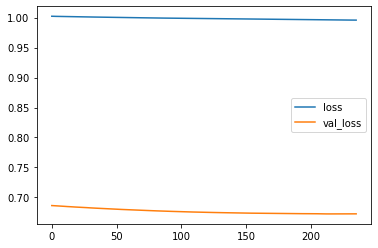

In [96]:
oPredictiveModel.fit(
    dfTransformedInputTrain, 
    dfScaledOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (dfTransformedInputValidation, dfScaledOutputValidation), callbacks=[oEarlyStop] )

oPredictiveModel.save_weights(sSubModelName)

pd.DataFrame(oPredictiveModel.history.history).plot()

## Test

In [97]:
oPredictiveModel.load_weights(sSubModelName)

aPrediction = oPredictiveModel.predict(dfTransformedInputTest)

sOutputScalerPath = os.path.join(sSubModelName , "__scalers__")
sOutputScalerPath = os.path.join(sOutputScalerPath , "output" + ".sav")
oScalerOutput = pickle.load(open(sOutputScalerPath, 'rb'))
aPrediction = oScalerOutput.inverse_transform(aPrediction)

dfPrediction = pd.DataFrame(aPrediction, index = dfScaledInputTest.index)
dfPrediction.columns = aColumns

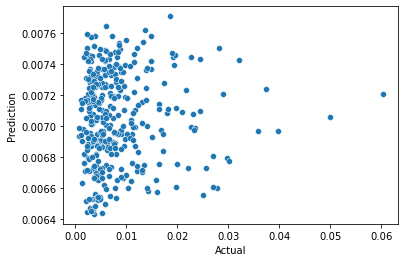

In [98]:
dfTestComparision = dfPrediction.join(dfOutputTest, how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]


sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction") 

In [99]:
error = dfOutputTest - dfPrediction

aMetrics = [
        ('mean absolute error', mean_absolute_error(dfOutputTest, dfPrediction)),
        ('median absolute error', median_absolute_error(dfOutputTest, dfPrediction)),
        ('mean squared error', mean_squared_error(dfOutputTest, dfPrediction)),
        ('max error', max_error(dfOutputTest, dfPrediction)),
        ('r2 score', r2_score(dfOutputTest, dfPrediction)),
        ('explained variance score', explained_variance_score(dfOutputTest, dfPrediction))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                0.005
    median absolute error:                0.003
       mean squared error:                0.000
                max error:                0.053
                 r2 score:               -0.023
 explained variance score:                0.002


# DOWNWARD REGRESSION MODEL